In [11]:
model = DiT(input_size=9,
        patch_size=1,
        in_channels=1,
        depth=12, hidden_size=384, num_heads=6,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1,
        learn_sigma=True,)

In [13]:

out = model(torch.randn(2, 1, 9, 9), torch.randn(2,), torch.ones(2, dtype=torch.long))
out.shape

torch.Size([2, 2, 9, 9])

In [1]:
import torch
import numpy as np
import logging
from time import time
from models import DiT
from train import requires_grad, deepcopy, update_ema
from diffusion import create_diffusion
import os
from easydict import EasyDict as edict
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
device = "cuda"

model = DiT(input_size=9,
        patch_size=1,
        in_channels=1,
        depth=12, hidden_size=384, num_heads=6,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1,
        learn_sigma=True,)


model = DiT(input_size=32,
        patch_size=4,
        in_channels=1,
        depth=12, hidden_size=384, num_heads=6,
        mlp_ratio=4.0,
        class_dropout_prob=1.0,
        num_classes=10,
        learn_sigma=True,)

In [2]:
args = edict(global_seed=42, epochs=10, num_workers=4, log_every=10, ckpt_every=1000)

logger = logging.getLogger(__name__)

logger.info(f"DiT Parameters: {sum(p.numel() for p in model.parameters()):,}")

model.to(device)
ema = deepcopy(model).to(device)  # Create an EMA of the model for use after training
requires_grad(ema, False)

diffusion = create_diffusion(timestep_respacing="") 
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)

In [4]:

print(f"DiT Parameters: {sum(p.numel() for p in model.parameters()):,}")
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((32, 32)),
                                transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST("~/Datasets", train=True, download=False, 
                         transform=transform)
loader = DataLoader(dataset, batch_size=256, shuffle=True, 
                    num_workers=args.num_workers,
                    pin_memory=True, drop_last=True)
#seed=args.global_seed)

DiT Parameters: 32,509,472


In [6]:
args.epochs = 20
# Prepare models for training:
update_ema(ema, model, decay=0) # .module  # Ensure EMA is initialized with synced weights

model.train()  # important! This enables embedding dropout for classifier-free guidance
ema.eval()  # EMA model should always be in eval mode
train_steps = 0
log_steps = 0
running_loss = 0
start_time = time()

logger.info(f"Training for {args.epochs} epochs...")
for epoch in range(args.epochs):
    # sampler.set_epoch(epoch)
    logger.info(f"Beginning epoch {epoch}...")
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        # with torch.no_grad():
        #     # Map input images to latent space + normalize latents:
        #     x = vae.encode(x).latent_dist.sample().mul_(0.18215)
        t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)
        model_kwargs = dict(y=y)
        loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
        loss = loss_dict["loss"].mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        update_ema(ema, model) # .module
        
        # Log loss values:
        running_loss += loss.item()
        log_steps += 1
        train_steps += 1
        if train_steps % args.log_every == 0:
            # Measure training speed:
            torch.cuda.synchronize()
            end_time = time()
            steps_per_sec = log_steps / (end_time - start_time)
            # Reduce loss history over all processes:
            avg_loss = torch.tensor(running_loss / log_steps, device=device)
            # dist.all_reduce(avg_loss, op=dist.ReduceOp.SUM)
            # avg_loss = avg_loss.item() / dist.get_world_size()
            logger.info(f"(step={train_steps:07d}) Train Loss: {avg_loss:.4f}, Train Steps/Sec: {steps_per_sec:.2f}")
            print (f"(step={train_steps:07d}) Train Loss: {avg_loss:.4f}, Train Steps/Sec: {steps_per_sec:.2f}")
            # Reset monitoring variables:
            running_loss = 0
            log_steps = 0
            start_time = time()

        # Save DiT checkpoint:
        if train_steps % args.ckpt_every == 0 and train_steps > 0:
            # if rank == 0:
            checkpoint = {
                "model": model.state_dict(), # .module
                "ema": ema.state_dict(),
                "opt": opt.state_dict(),
                "args": args
            }
            checkpoint_path = f"{checkpoint_dir}/{train_steps:07d}.pt"
            torch.save(checkpoint, checkpoint_path)
            logger.info(f"Saved checkpoint to {checkpoint_path}")
            # dist.barrier()

model.eval()  # important! This disables randomized embedding dropout
# do any sampling/FID calculation/etc. with ema (or model) in eval mode ...

logger.info("Done!")
# cleanup()

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

(step=0000010) Train Loss: 0.0449, Train Steps/Sec: 9.10
(step=0000020) Train Loss: 0.0416, Train Steps/Sec: 14.90
(step=0000030) Train Loss: 0.0386, Train Steps/Sec: 14.91
(step=0000040) Train Loss: 0.0423, Train Steps/Sec: 14.91
(step=0000050) Train Loss: 0.0403, Train Steps/Sec: 14.89
(step=0000060) Train Loss: 0.0409, Train Steps/Sec: 14.91
(step=0000070) Train Loss: 0.0399, Train Steps/Sec: 14.90
(step=0000080) Train Loss: 0.0378, Train Steps/Sec: 14.91
(step=0000090) Train Loss: 0.0391, Train Steps/Sec: 14.91
(step=0000100) Train Loss: 0.0400, Train Steps/Sec: 14.90
(step=0000110) Train Loss: 0.0425, Train Steps/Sec: 14.89
(step=0000120) Train Loss: 0.0404, Train Steps/Sec: 14.90
(step=0000130) Train Loss: 0.0392, Train Steps/Sec: 14.89
(step=0000140) Train Loss: 0.0434, Train Steps/Sec: 14.91
(step=0000150) Train Loss: 0.0424, Train Steps/Sec: 14.91
(step=0000160) Train Loss: 0.0425, Train Steps/Sec: 14.90
(step=0000170) Train Loss: 0.0425, Train Steps/Sec: 14.91
(step=0000180) 

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

(step=0000240) Train Loss: 0.0401, Train Steps/Sec: 8.82
(step=0000250) Train Loss: 0.0380, Train Steps/Sec: 14.94
(step=0000260) Train Loss: 0.0401, Train Steps/Sec: 14.92
(step=0000270) Train Loss: 0.0392, Train Steps/Sec: 14.92
(step=0000280) Train Loss: 0.0394, Train Steps/Sec: 14.91
(step=0000290) Train Loss: 0.0398, Train Steps/Sec: 14.92
(step=0000300) Train Loss: 0.0385, Train Steps/Sec: 14.91
(step=0000310) Train Loss: 0.0366, Train Steps/Sec: 14.92
(step=0000320) Train Loss: 0.0422, Train Steps/Sec: 14.91
(step=0000330) Train Loss: 0.0388, Train Steps/Sec: 14.92
(step=0000340) Train Loss: 0.0367, Train Steps/Sec: 14.91
(step=0000350) Train Loss: 0.0374, Train Steps/Sec: 14.92
(step=0000360) Train Loss: 0.0415, Train Steps/Sec: 14.91
(step=0000370) Train Loss: 0.0416, Train Steps/Sec: 14.91
(step=0000380) Train Loss: 0.0380, Train Steps/Sec: 14.91
(step=0000390) Train Loss: 0.0353, Train Steps/Sec: 14.90
(step=0000400) Train Loss: 0.0418, Train Steps/Sec: 14.91
(step=0000410) 

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

(step=0000470) Train Loss: 0.0395, Train Steps/Sec: 8.85
(step=0000480) Train Loss: 0.0375, Train Steps/Sec: 14.88
(step=0000490) Train Loss: 0.0430, Train Steps/Sec: 14.90
(step=0000500) Train Loss: 0.0403, Train Steps/Sec: 14.90
(step=0000510) Train Loss: 0.0394, Train Steps/Sec: 14.91
(step=0000520) Train Loss: 0.0400, Train Steps/Sec: 14.89
(step=0000530) Train Loss: 0.0379, Train Steps/Sec: 14.88
(step=0000540) Train Loss: 0.0415, Train Steps/Sec: 14.90
(step=0000550) Train Loss: 0.0364, Train Steps/Sec: 14.89
(step=0000560) Train Loss: 0.0387, Train Steps/Sec: 14.91
(step=0000570) Train Loss: 0.0373, Train Steps/Sec: 14.91
(step=0000580) Train Loss: 0.0380, Train Steps/Sec: 14.90
(step=0000590) Train Loss: 0.0408, Train Steps/Sec: 14.90
(step=0000600) Train Loss: 0.0363, Train Steps/Sec: 14.91
(step=0000610) Train Loss: 0.0411, Train Steps/Sec: 14.90
(step=0000620) Train Loss: 0.0391, Train Steps/Sec: 14.90
(step=0000630) Train Loss: 0.0374, Train Steps/Sec: 14.91
(step=0000640) 

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

(step=0000710) Train Loss: 0.0355, Train Steps/Sec: 9.06
(step=0000720) Train Loss: 0.0364, Train Steps/Sec: 14.90
(step=0000730) Train Loss: 0.0386, Train Steps/Sec: 14.90
(step=0000740) Train Loss: 0.0386, Train Steps/Sec: 14.92
(step=0000750) Train Loss: 0.0394, Train Steps/Sec: 14.92
(step=0000760) Train Loss: 0.0384, Train Steps/Sec: 14.92
(step=0000770) Train Loss: 0.0380, Train Steps/Sec: 14.92
(step=0000780) Train Loss: 0.0380, Train Steps/Sec: 14.92
(step=0000790) Train Loss: 0.0393, Train Steps/Sec: 14.93
(step=0000800) Train Loss: 0.0352, Train Steps/Sec: 14.89
(step=0000810) Train Loss: 0.0386, Train Steps/Sec: 14.91
(step=0000820) Train Loss: 0.0401, Train Steps/Sec: 14.92
(step=0000830) Train Loss: 0.0392, Train Steps/Sec: 14.92
(step=0000840) Train Loss: 0.0380, Train Steps/Sec: 14.92
(step=0000850) Train Loss: 0.0373, Train Steps/Sec: 14.92
(step=0000860) Train Loss: 0.0363, Train Steps/Sec: 14.92
(step=0000870) Train Loss: 0.0389, Train Steps/Sec: 14.92
(step=0000880) 

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

(step=0000940) Train Loss: 0.0370, Train Steps/Sec: 8.85
(step=0000950) Train Loss: 0.0347, Train Steps/Sec: 14.93
(step=0000960) Train Loss: 0.0384, Train Steps/Sec: 14.91
(step=0000970) Train Loss: 0.0377, Train Steps/Sec: 14.91
(step=0000980) Train Loss: 0.0357, Train Steps/Sec: 14.91
(step=0000990) Train Loss: 0.0385, Train Steps/Sec: 14.92
(step=0001000) Train Loss: 0.0372, Train Steps/Sec: 14.92
(step=0001010) Train Loss: 0.0398, Train Steps/Sec: 1.63
(step=0001020) Train Loss: 0.0409, Train Steps/Sec: 14.90
(step=0001030) Train Loss: 0.0399, Train Steps/Sec: 14.91
(step=0001040) Train Loss: 0.0400, Train Steps/Sec: 14.91
(step=0001050) Train Loss: 0.0392, Train Steps/Sec: 14.91
(step=0001060) Train Loss: 0.0399, Train Steps/Sec: 14.90
(step=0001070) Train Loss: 0.0377, Train Steps/Sec: 14.91
(step=0001080) Train Loss: 0.0359, Train Steps/Sec: 14.90
(step=0001090) Train Loss: 0.0361, Train Steps/Sec: 14.90
(step=0001100) Train Loss: 0.0380, Train Steps/Sec: 14.91
(step=0001110) T

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

(step=0001180) Train Loss: 0.0370, Train Steps/Sec: 8.78
(step=0001190) Train Loss: 0.0378, Train Steps/Sec: 14.92
(step=0001200) Train Loss: 0.0361, Train Steps/Sec: 14.90
(step=0001210) Train Loss: 0.0348, Train Steps/Sec: 14.89
(step=0001220) Train Loss: 0.0375, Train Steps/Sec: 14.89
(step=0001230) Train Loss: 0.0378, Train Steps/Sec: 14.87
(step=0001240) Train Loss: 0.0386, Train Steps/Sec: 14.90
(step=0001250) Train Loss: 0.0364, Train Steps/Sec: 14.90
(step=0001260) Train Loss: 0.0386, Train Steps/Sec: 14.88
(step=0001270) Train Loss: 0.0400, Train Steps/Sec: 14.91
(step=0001280) Train Loss: 0.0377, Train Steps/Sec: 14.90
(step=0001290) Train Loss: 0.0379, Train Steps/Sec: 14.90
(step=0001300) Train Loss: 0.0357, Train Steps/Sec: 14.90
(step=0001310) Train Loss: 0.0408, Train Steps/Sec: 14.90
(step=0001320) Train Loss: 0.0368, Train Steps/Sec: 14.93
(step=0001330) Train Loss: 0.0378, Train Steps/Sec: 14.89
(step=0001340) Train Loss: 0.0371, Train Steps/Sec: 14.90
(step=0001350) 

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

(step=0001410) Train Loss: 0.0347, Train Steps/Sec: 9.30
(step=0001420) Train Loss: 0.0375, Train Steps/Sec: 14.93
(step=0001430) Train Loss: 0.0422, Train Steps/Sec: 14.89
(step=0001440) Train Loss: 0.0372, Train Steps/Sec: 14.91
(step=0001450) Train Loss: 0.0375, Train Steps/Sec: 14.91
(step=0001460) Train Loss: 0.0348, Train Steps/Sec: 14.90
(step=0001470) Train Loss: 0.0367, Train Steps/Sec: 14.91
(step=0001480) Train Loss: 0.0371, Train Steps/Sec: 14.91
(step=0001490) Train Loss: 0.0336, Train Steps/Sec: 14.90
(step=0001500) Train Loss: 0.0342, Train Steps/Sec: 14.90
(step=0001510) Train Loss: 0.0370, Train Steps/Sec: 14.90
(step=0001520) Train Loss: 0.0395, Train Steps/Sec: 14.91
(step=0001530) Train Loss: 0.0373, Train Steps/Sec: 14.90
(step=0001540) Train Loss: 0.0343, Train Steps/Sec: 14.91
(step=0001550) Train Loss: 0.0366, Train Steps/Sec: 14.91
(step=0001560) Train Loss: 0.0361, Train Steps/Sec: 14.91
(step=0001570) Train Loss: 0.0373, Train Steps/Sec: 14.90
(step=0001580) 

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

(step=0001640) Train Loss: 0.0377, Train Steps/Sec: 8.83
(step=0001650) Train Loss: 0.0381, Train Steps/Sec: 14.95
(step=0001660) Train Loss: 0.0376, Train Steps/Sec: 14.90
(step=0001670) Train Loss: 0.0356, Train Steps/Sec: 14.90
(step=0001680) Train Loss: 0.0355, Train Steps/Sec: 14.90
(step=0001690) Train Loss: 0.0388, Train Steps/Sec: 14.91
(step=0001700) Train Loss: 0.0343, Train Steps/Sec: 14.91
(step=0001710) Train Loss: 0.0335, Train Steps/Sec: 14.91
(step=0001720) Train Loss: 0.0342, Train Steps/Sec: 14.90
(step=0001730) Train Loss: 0.0316, Train Steps/Sec: 14.90
(step=0001740) Train Loss: 0.0360, Train Steps/Sec: 14.92
(step=0001750) Train Loss: 0.0363, Train Steps/Sec: 14.87
(step=0001760) Train Loss: 0.0329, Train Steps/Sec: 14.91
(step=0001770) Train Loss: 0.0324, Train Steps/Sec: 14.91
(step=0001780) Train Loss: 0.0345, Train Steps/Sec: 14.91
(step=0001790) Train Loss: 0.0340, Train Steps/Sec: 14.90
(step=0001800) Train Loss: 0.0342, Train Steps/Sec: 14.91
(step=0001810) 

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

(step=0001880) Train Loss: 0.0323, Train Steps/Sec: 8.80
(step=0001890) Train Loss: 0.0346, Train Steps/Sec: 14.94
(step=0001900) Train Loss: 0.0312, Train Steps/Sec: 14.92
(step=0001910) Train Loss: 0.0330, Train Steps/Sec: 14.92
(step=0001920) Train Loss: 0.0348, Train Steps/Sec: 14.92
(step=0001930) Train Loss: 0.0317, Train Steps/Sec: 14.92
(step=0001940) Train Loss: 0.0299, Train Steps/Sec: 14.91
(step=0001950) Train Loss: 0.0334, Train Steps/Sec: 14.91
(step=0001960) Train Loss: 0.0312, Train Steps/Sec: 14.88
(step=0001970) Train Loss: 0.0322, Train Steps/Sec: 14.88
(step=0001980) Train Loss: 0.0308, Train Steps/Sec: 14.90
(step=0001990) Train Loss: 0.0294, Train Steps/Sec: 14.91
(step=0002000) Train Loss: 0.0297, Train Steps/Sec: 14.91
(step=0002010) Train Loss: 0.0324, Train Steps/Sec: 1.91
(step=0002020) Train Loss: 0.0328, Train Steps/Sec: 14.92
(step=0002030) Train Loss: 0.0325, Train Steps/Sec: 14.92
(step=0002040) Train Loss: 0.0310, Train Steps/Sec: 14.90
(step=0002050) T

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

(step=0002110) Train Loss: 0.0300, Train Steps/Sec: 8.97
(step=0002120) Train Loss: 0.0284, Train Steps/Sec: 14.96
(step=0002130) Train Loss: 0.0313, Train Steps/Sec: 14.91
(step=0002140) Train Loss: 0.0280, Train Steps/Sec: 14.90
(step=0002150) Train Loss: 0.0293, Train Steps/Sec: 14.91
(step=0002160) Train Loss: 0.0320, Train Steps/Sec: 14.92
(step=0002170) Train Loss: 0.0275, Train Steps/Sec: 14.92
(step=0002180) Train Loss: 0.0272, Train Steps/Sec: 14.92
(step=0002190) Train Loss: 0.0257, Train Steps/Sec: 14.92
(step=0002200) Train Loss: 0.0271, Train Steps/Sec: 14.91
(step=0002210) Train Loss: 0.0301, Train Steps/Sec: 14.92
(step=0002220) Train Loss: 0.0283, Train Steps/Sec: 14.92
(step=0002230) Train Loss: 0.0302, Train Steps/Sec: 14.91
(step=0002240) Train Loss: 0.0277, Train Steps/Sec: 14.92
(step=0002250) Train Loss: 0.0291, Train Steps/Sec: 14.90
(step=0002260) Train Loss: 0.0289, Train Steps/Sec: 14.91
(step=0002270) Train Loss: 0.0304, Train Steps/Sec: 14.91
(step=0002280) 

In [24]:
class_labels = np.random.randint(0, 10, 32) 
n = len(class_labels)
z = torch.randn(n, 1, 32, 32, device=device)
y = torch.tensor(class_labels, device=device)
# Setup classifier-free guidance:
# z = torch.cat([z, z], 0)
# y_null = torch.tensor([1000] * n, device=device)
# y = torch.cat([y, y_null], 0)
# model_kwargs = dict(y=y, cfg_scale=args.cfg_scale)
model_kwargs = dict(y=y, )
# Sample images:
# samples = diffusion.p_sample_loop(
#     model.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
# )
samples = diffusion.p_sample_loop(
    model.forward, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
)
# samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
# samples = vae.decode(samples / 0.18215).sample
samples = (0.5 * samples + 0.5)


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


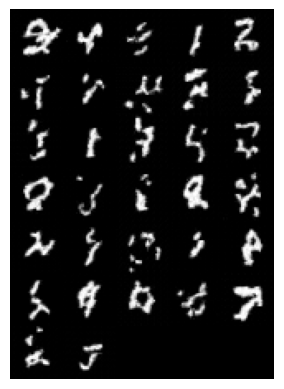

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
# Assuming 'samples' is the variable containing the samples
# Reshape the samples into a grid
grid_size = int(np.sqrt(samples.shape[0]))
montage = make_grid(samples.detach().cpu(), nrow=grid_size, padding=0)
# montage = np.transpose(samples, (0, 2, 3, 1)).reshape(grid_size, grid_size, samples.shape[2], samples.shape[3])
fig, ax = plt.subplots()
ax.imshow(montage.permute(1, 2, 0))
ax.axis('off')
plt.show()


In [27]:

import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
dist.init_process_group("nccl")

ValueError: Error initializing torch.distributed using env:// rendezvous: environment variable RANK expected, but not set

## sample

In [35]:
model = DiT(input_size=32,
        patch_size=4,
        in_channels=1,
        depth=12, hidden_size=384, num_heads=6,
        mlp_ratio=4.0,
        class_dropout_prob=1.0,
        num_classes=10,
        learn_sigma=True,)
state_dict = torch.load("/n/home12/binxuwang/Github/DiT/results/004-DiT-XL-2/checkpoints/0110000.pt")
model.load_state_dict(state_dict["model"])

<All keys matched successfully>

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 255.5, 255.5, -0.5)

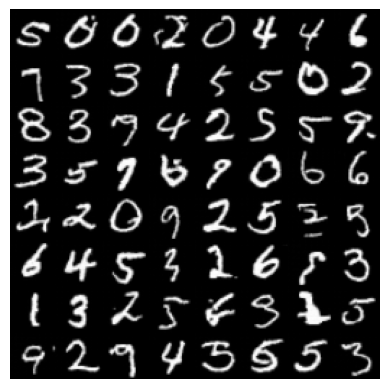

In [51]:
diffusion = create_diffusion(timestep_respacing="")
model.eval().cuda()
z = torch.randn(64, 1, 32, 32, device=device)
y = torch.randint(0, 10, (64,), device=device)
model_kwargs = dict(y=y)
with torch.no_grad():
    samples = diffusion.p_sample_loop(model, z.shape, z, model_kwargs=model_kwargs, progress=True, device=device)
samples = (0.5 * samples + 0.5).clamp(0, 1)
plt.imshow(make_grid(samples, nrow=8, padding=0).permute(1, 2, 0).cpu().numpy())
plt.axis('off')

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 255.5, 255.5, -0.5)

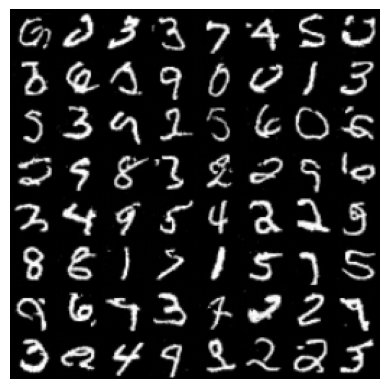

In [61]:
diffusion = create_diffusion(timestep_respacing="", diffusion_steps=1000)
model.eval().cuda()
z = torch.randn(1024, 1, 32, 32, device=device)
y = torch.randint(0, 10, (1024,), device=device)
model_kwargs = dict(y=y)
with torch.no_grad():
    samples = diffusion.ddim_sample_loop(model, z.shape, z, model_kwargs=model_kwargs, progress=True, device=device)
samples = (0.5 * samples + 0.5).clamp(0, 1)
plt.imshow(make_grid(samples[:64], nrow=8, padding=0).permute(1, 2, 0).cpu().numpy())
plt.axis('off')

  0%|          | 0/100 [00:00<?, ?it/s]

(-0.5, 255.5, 255.5, -0.5)

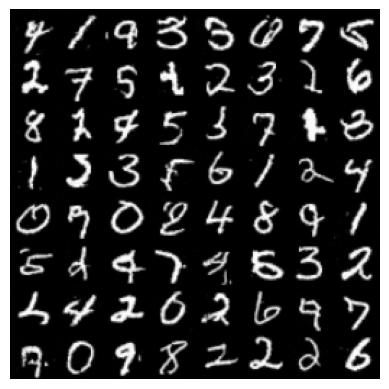

In [64]:
diffusion = create_diffusion(timestep_respacing="ddim100", diffusion_steps=1000)
model.eval().cuda()
z = torch.randn(1024, 1, 32, 32, device=device)
y = torch.randint(0, 10, (1024,), device=device)
model_kwargs = dict(y=y)
with torch.no_grad():
    samples = diffusion.ddim_sample_loop(model, z.shape, z, model_kwargs=model_kwargs, progress=True, device=device)
samples = (0.5 * samples + 0.5).clamp(0, 1)
plt.imshow(make_grid(samples[:64], nrow=8, padding=0).permute(1, 2, 0).cpu().numpy())
plt.axis('off')

### RAVEN Rule checking for DiT

In [46]:
from tqdm import tqdm, trange
import os
from os.path import join
import torch
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
from edm_utils import parse_train_logfile
from dataset_utils import onehot2attr_tsr
from stats_plot_utils import estimate_CI, shaded_error
from rule_utils import get_rule_list, get_obj_list, get_rule_img, check_consistent

def batch_load_samples_infer_rules(samples_dir, epoch_list, encoding="onehot"):
    rules_all = []
    for epoch in tqdm(epoch_list): 
        # if not os.path.exists(join(samples_dir, 'tensor_'+str(epoch)+'.pt')):
        #     print(epoch, "not exist")
        #     break
        # samples = torch.load(join(samples_dir, 'tensor_'+str(epoch)+'.pt')) # (batch, 27, 9, 9)
        if not os.path.exists(join(samples_dir, f'{epoch:07d}.pt')):
            print(epoch, "not exist")
            break
        samples = torch.load(join(samples_dir, f'{epoch:07d}.pt')) # (batch, 27, 9, 9)
        if encoding == "onehot":
            attr_tsr_list = onehot2attr_tsr(samples, threshold=0.5)
        elif encoding == "digit":
            attr_tsr_list = torch.round(samples).int() # (batch, 3, 9, 9)
        else:
            raise ValueError("encoding should be onehot or digit")
        rules_list = []
        for i, attr_tsr in enumerate(attr_tsr_list): 
            rule_img = get_rule_img(attr_tsr) # (3, 9, 9) -> (3,)
            rules_list.append(rule_img)
        rules_all.append(rules_list)
    rules_all = np.asarray(rules_all) # (201, 25, 3)
    epoch_list = epoch_list[:len(rules_all)]
    
    consistent_mat = []
    for epoch_i in trange(len(rules_all)): 
        consistent_all = [check_consistent(rules) 
                          for rules in rules_all[epoch_i]]
        consistent_mat.append(consistent_all)
    consistent_mat = np.asarray(consistent_mat)
    return rules_all, consistent_mat, epoch_list



def visualize_consistency(epoch_list, consistent_mat, title_str="Wide Dep x3 Blnr", figname="RAVEN10_abstract_BigBlnr", figdir="../Figures", ):
    sample_size = consistent_mat.shape[1]
    fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI((consistent_mat == 1).sum(axis=1), sample_size, alpha=0.05)
    shaded_error(plt.gca(), epoch_list, (consistent_mat == 1).mean(axis=1),
                    CI_low, CI_high, label="Same in 3 rows", color="C0")
    CI_low, CI_high = estimate_CI((consistent_mat == 2).sum(axis=1), sample_size, alpha=0.05)
    shaded_error(plt.gca(), epoch_list, (consistent_mat==2).mean(axis=1),
                    CI_low, CI_high, label="Same in 2 rows", color="C1")
    ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}, uncond Diffusion")
    ax.legend()
    # fig.savefig(join(figdir,f"{figname}_rule_consistency.pdf"), dpi=300, )#bbox_inches='tight')
    # fig.savefig(join(figdir,f"{figname}_rule_consistency.png"), dpi=300, )#bbox_inches='tight')
    return fig
    
    
def visualize_rule_validity(epoch_list, rules_all, title_str="Wide Dep x3 Blnr", figname="RAVEN10_abstract_BigBlnr", figdir="../Figures", ):
    sample_size = rules_all.shape[1]
    row_num = rules_all.shape[2]
    fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI((rules_all != -1).sum(axis=(1,2)), sample_size * row_num, alpha=0.05)
    shaded_error(plt.gca(), epoch_list, (rules_all != -1).mean(axis=(1,2)),
                    CI_low, CI_high, label="valid row", color="C2")
    ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}, uncond Diffusion")
    ax.legend()
    # fig.savefig(join(figdir,f"{figname}_rule_valid.pdf"), dpi=300, )#bbox_inches='tight')
    # fig.savefig(join(figdir,f"{figname}_rule_valid.png"), dpi=300, )#bbox_inches='tight')
    return fig

 10%|██████████████████████                                                                                                                                                                                                    | 10/99 [00:11<01:40,  1.13s/it]


11000 not exist


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 231.71it/s]


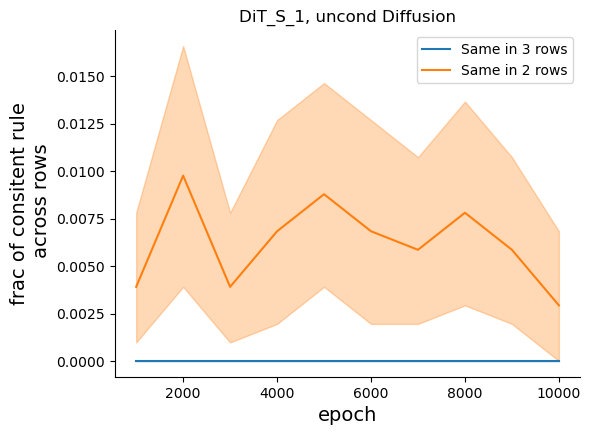

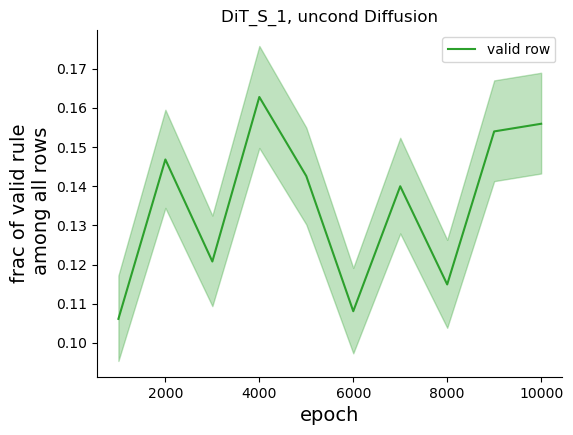

In [65]:
figname = "DiT_S_1"
title_str = "DiT_S_1"
rules_all, consistent_mat, epoch_list = batch_load_samples_infer_rules("/n/home12/binxuwang/Github/DiT/results/006-DiT_S_1/samples", 
                                                                       list(range(1000, 100000, 1000)), encoding="digit")

visualize_consistency(epoch_list, consistent_mat, 
                    title_str=title_str, figname=figname, figdir="",)

visualize_rule_validity(epoch_list, rules_all, 
                        title_str=title_str, figname=figname, figdir="",);

In [49]:
# count the unique values in consistent_mat
unique, counts = np.unique(consistent_mat, return_counts=True)
for u, c in zip(unique, counts): 
    print(u, c)

0 2651
2 25
3 1420


### Old obsolete 

In [ ]:
# Setup data:
# transform = transforms.Compose([
#     transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, args.image_size)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
# ])
# dataset = ImageFolder(args.data_path, transform=transform)
# sampler = DistributedSampler(
#     dataset,
#     num_replicas=dist.get_world_size(),
#     rank=rank,
#     shuffle=True,
#     seed=args.global_seed
# )
# loader = DataLoader(
#     dataset,
#     batch_size=int(args.global_batch_size // dist.get_world_size()),
#     shuffle=False,
#     sampler=sampler,
#     num_workers=args.num_workers,
#     pin_memory=True,
#     drop_last=True
# )
# logger.info(f"Dataset contains {len(dataset):,} images ({args.data_path})")

In [ ]:
# Prepare models for training:
update_ema(ema, model.module, decay=0)  # Ensure EMA is initialized with synced weights
model.train()  # important! This enables embedding dropout for classifier-free guidance
ema.eval()  # EMA model should always be in eval mode

# Variables for monitoring/logging purposes:
train_steps = 0
log_steps = 0
running_loss = 0
start_time = time()

logger.info(f"Training for {args.epochs} epochs...")
for epoch in range(args.epochs):
    # sampler.set_epoch(epoch)
    logger.info(f"Beginning epoch {epoch}...")
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        # with torch.no_grad():
        #     # Map input images to latent space + normalize latents:
        #     x = vae.encode(x).latent_dist.sample().mul_(0.18215)
        t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)
        model_kwargs = dict(y=y)
        loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
        loss = loss_dict["loss"].mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        update_ema(ema, model.module)

        # Log loss values:
        running_loss += loss.item()
        log_steps += 1
        train_steps += 1
        if train_steps % args.log_every == 0:
            # Measure training speed:
            torch.cuda.synchronize()
            end_time = time()
            steps_per_sec = log_steps / (end_time - start_time)
            # Reduce loss history over all processes:
            avg_loss = torch.tensor(running_loss / log_steps, device=device)
            # dist.all_reduce(avg_loss, op=dist.ReduceOp.SUM)
            # avg_loss = avg_loss.item() / dist.get_world_size()
            logger.info(f"(step={train_steps:07d}) Train Loss: {avg_loss:.4f}, Train Steps/Sec: {steps_per_sec:.2f}")
            # Reset monitoring variables:
            running_loss = 0
            log_steps = 0
            start_time = time()

        # Save DiT checkpoint:
        if train_steps % args.ckpt_every == 0 and train_steps > 0:
            # if rank == 0:
            checkpoint = {
                "model": model.module.state_dict(),
                "ema": ema.state_dict(),
                "opt": opt.state_dict(),
                "args": args
            }
            checkpoint_path = f"{checkpoint_dir}/{train_steps:07d}.pt"
            torch.save(checkpoint, checkpoint_path)
            logger.info(f"Saved checkpoint to {checkpoint_path}")
            # dist.barrier()

model.eval()  # important! This disables randomized embedding dropout
# do any sampling/FID calculation/etc. with ema (or model) in eval mode ...

logger.info("Done!")
# cleanup()